# Breast Cancer Winsconsin

In [1]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import plotly.express as px
import plotly.graph_objs as go
# import graphviz, pydotplus
from IPython.display import Image
import re


os.chdir("C:/Users/etien/Documents/CCI/_HUB/cours/2024-2025/big_data/_git/MachineLearning/donnees")


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.tree import DecisionTreeClassifier,export_graphviz

# Outils du document

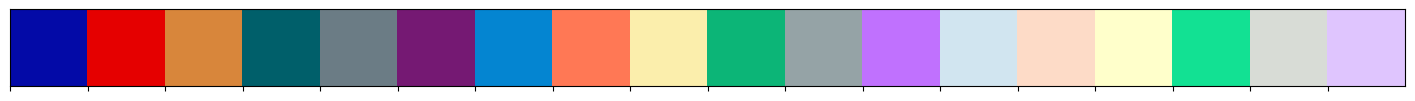

In [3]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))

In [4]:
repertoireRacine  = '.'
nomProjet         = "Penguins-Analyse exploratoire des données"

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet)
controleExistenceRepertoire(repertoireDonnees)
controleExistenceRepertoire(repertoireImages)

True

# Lecture des données

In [5]:
donnees = pd.read_csv("Breast Cancer Wisconsin/data.csv", 
             na_values='mq', 
             dtype={'numer_sta':str,'date':str}).iloc[:,1:]
donnees.drop(columns=['Unnamed: 32'], inplace=True)
donnees.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [6]:
donnees.sample(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
70,M,18.94,21.31,123.60,1130.0,0.09009,0.10290,0.108000,0.07951,0.1582,...,24.86,26.58,165.90,1866.0,0.1193,0.23360,0.26870,0.17890,0.2551,0.06589
517,M,19.89,20.26,130.50,1214.0,0.10370,0.13100,0.141100,0.09431,0.1802,...,23.73,25.23,160.50,1646.0,0.1417,0.33090,0.41850,0.16130,0.2549,0.09136
423,B,13.66,19.13,89.46,575.3,0.09057,0.11470,0.096570,0.04812,0.1848,...,15.14,25.50,101.40,708.8,0.1147,0.31670,0.36600,0.14070,0.2744,0.08839
51,B,13.64,16.34,87.21,571.8,0.07685,0.06059,0.018570,0.01723,0.1353,...,14.67,23.19,96.08,656.7,0.1089,0.15820,0.10500,0.08586,0.2346,0.08025
179,B,12.81,13.06,81.29,508.8,0.08739,0.03774,0.009193,0.01330,0.1466,...,13.63,16.15,86.70,570.7,0.1162,0.05445,0.02758,0.03990,0.1783,0.07319


In [7]:
donnees.columns

# donnees.filter(regex='(mean|diagnosis)$', axis=1)

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

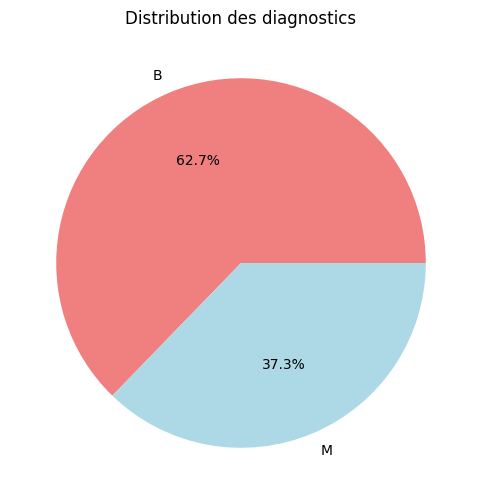

In [8]:
plt.figure(figsize=(8, 6))
diagnosis_counts = donnees['diagnosis'].value_counts()
plt.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%',
        colors=['lightcoral', 'lightblue'])
plt.title('Distribution des diagnostics')
plt.show()

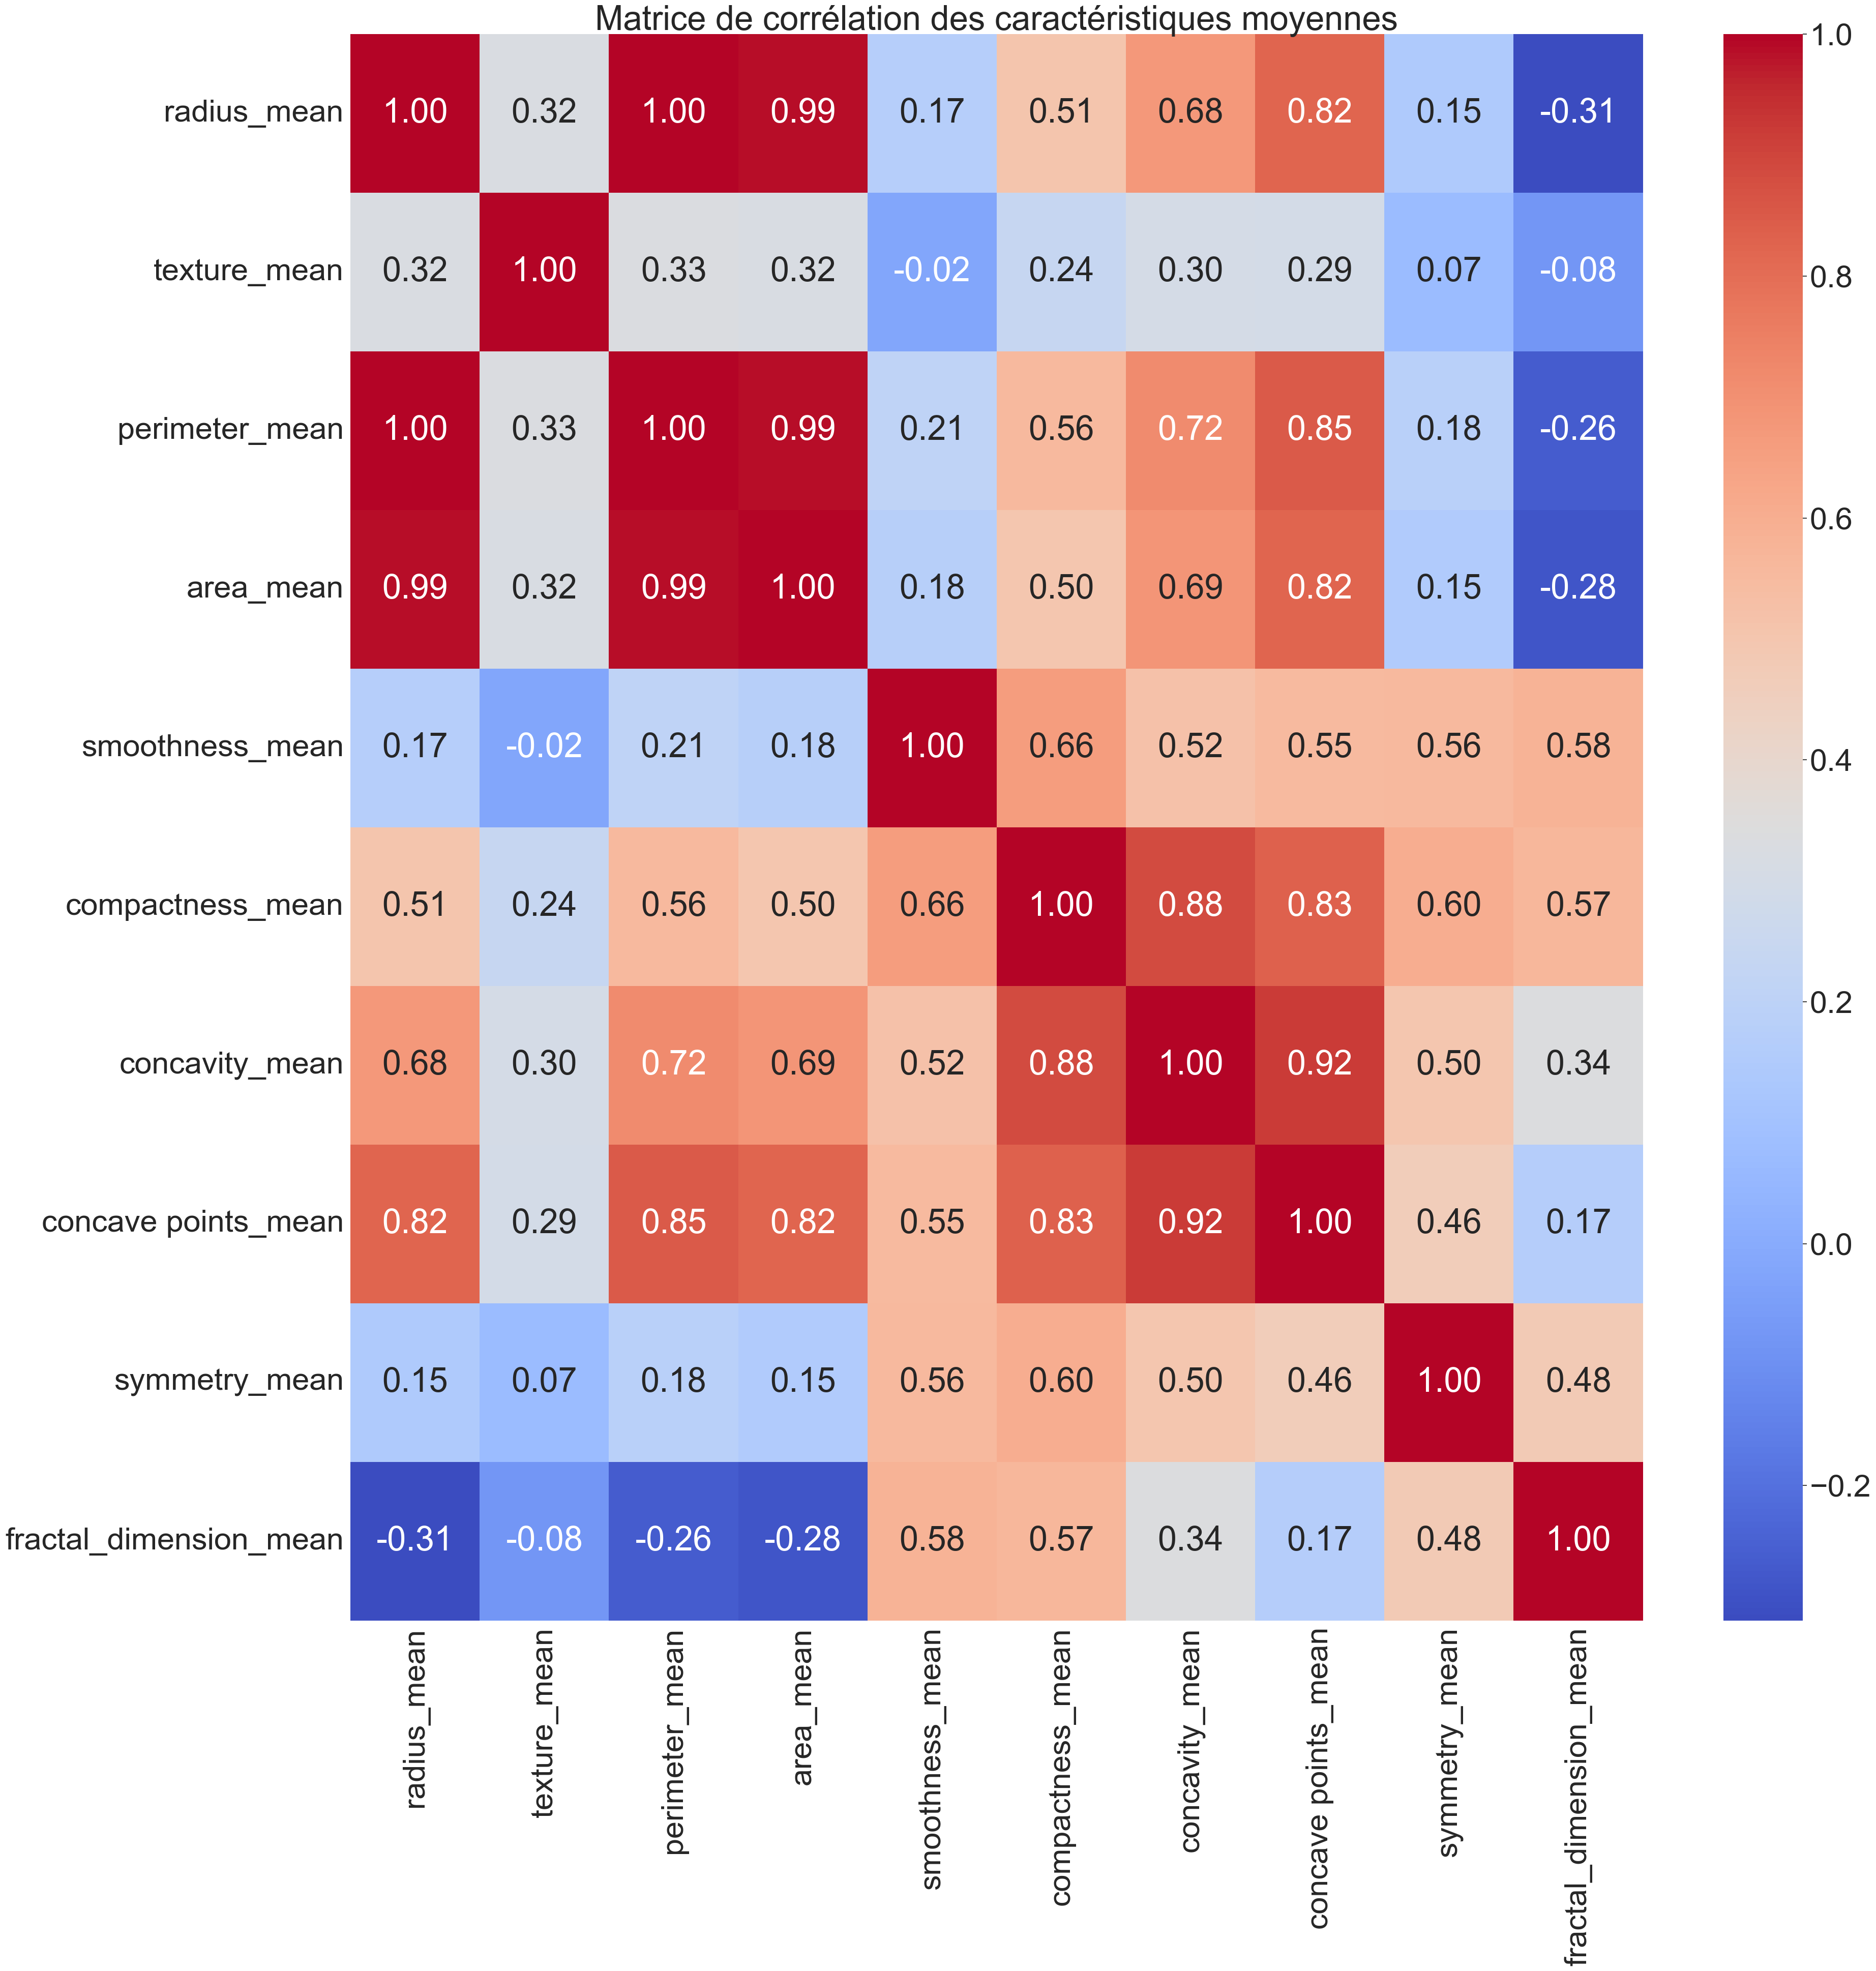

In [14]:
sns.set(font_scale=4)
mean_cols = [col for col in donnees.columns if 'mean' in col]
plt.figure(figsize=(40, 40))
sns.heatmap(donnees[mean_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation des caractéristiques moyennes')
plt.tight_layout()
plt.show()

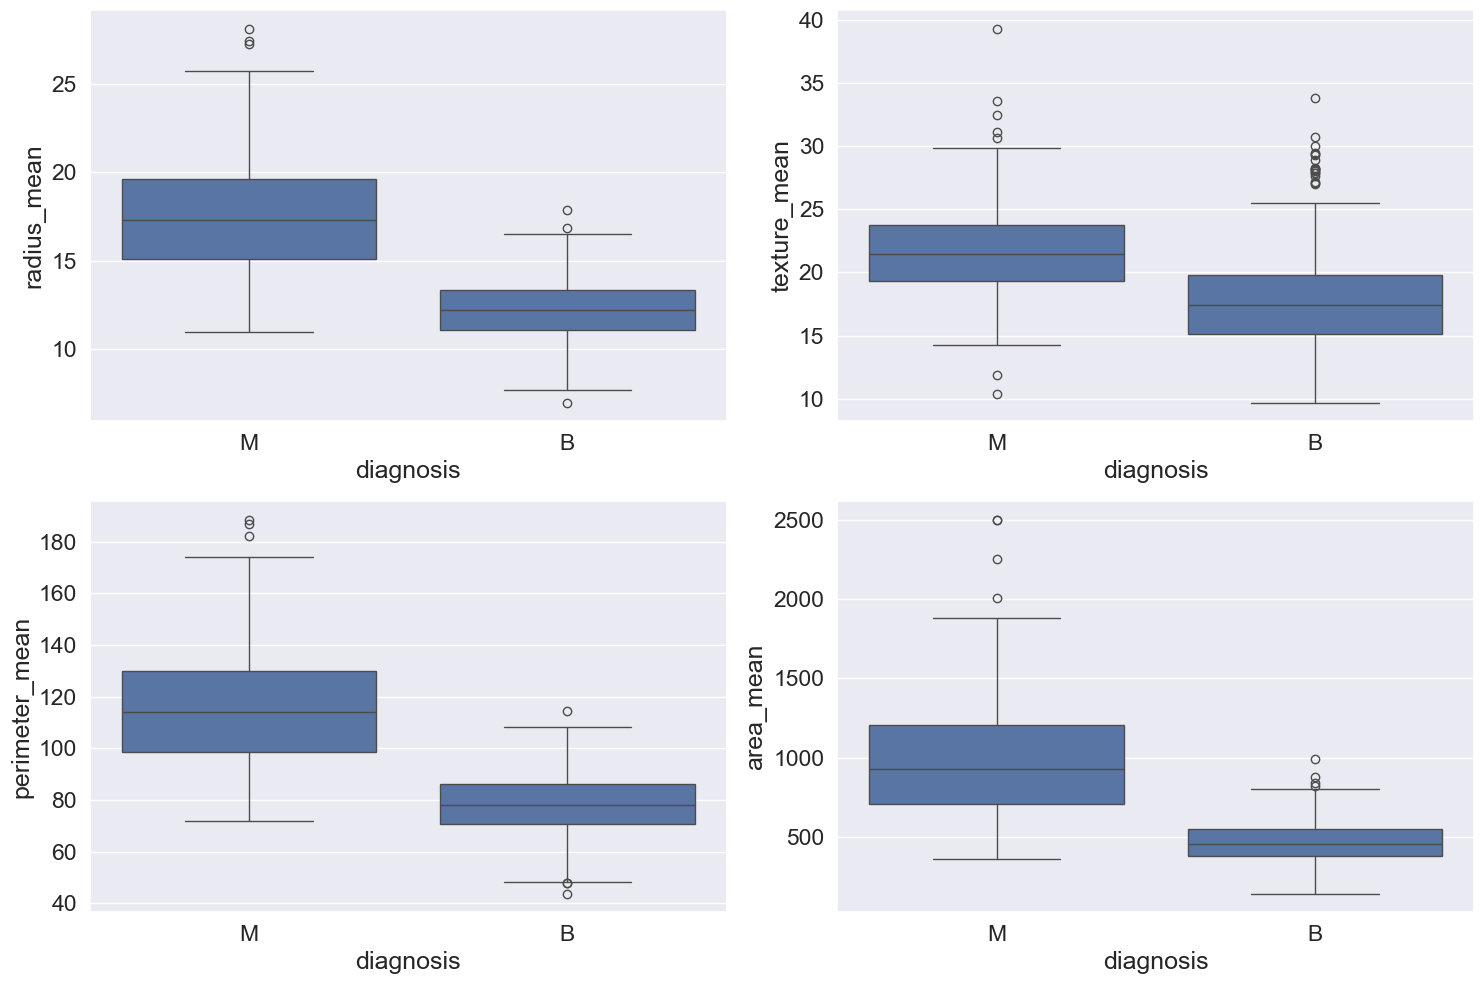

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.set(font_scale=1)
features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
for ax, feature in zip(axes.ravel(), features):
    sns.boxplot(data=donnees, x='diagnosis', y=feature, ax=ax)
plt.tight_layout()
plt.show()

<Figure size 4000x4000 with 0 Axes>

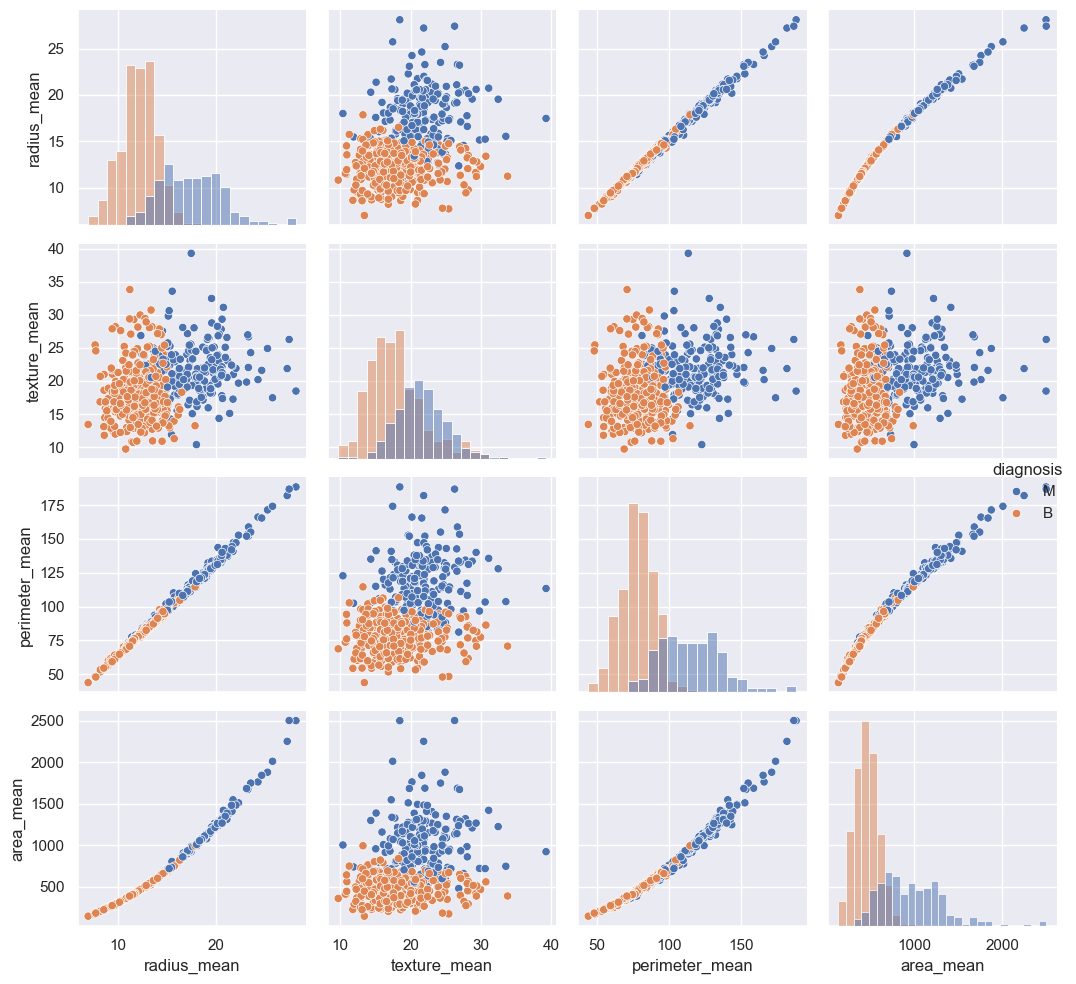

In [18]:
key_features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'diagnosis']
plt.figure(figsize=(40, 40))
sub_Plots = sns.pairplot(donnees[key_features], hue='diagnosis', diag_kind='hist')

#for ax in sub_Plots.axes.flatten():
#    ax.set_xlabel(ax.get_xlabel(), rotation = 75)
#    ax.set_ylabel(ax.get_ylabel(), rotation = 45)
    

#plt.subplots_adjust(hspace = 4, wspace=4)
plt.tight_layout()
plt.show()